In [44]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import time
from datetime import datetime
from tweepy import API
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json
import gzip
from collections import defaultdict
from gensim.models import Word2Vec
from nltk.stem.porter import *
from sklearn import linear_model
from sklearn.manifold import TSNE
import string
from xgboost import XGBRegressor, XGBClassifier
import spacy
import en_core_web_sm
import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from collections import Counter, defaultdict
import itertools
import ast
import os
import pickle

In [2]:
# read data

df = pd.read_json('renttherunway_final_data.json.gz', lines=True)

In [3]:
df.head() # this is how the data looks like

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


In [4]:
df.shape

(192544, 15)

In [5]:
# missing values per column

df.isna().sum()

fit                   0
user_id               0
bust size         18411
item_id               0
weight            29982
rating               82
rented for           10
review_text           0
body type         14637
review_summary        0
category              0
height              677
size                  0
age                 960
review_date           0
dtype: int64

In [6]:
# dropping all rows missing values

df = df.dropna()
df = df.reset_index(drop = True)

In [7]:
df.shape

(146381, 15)

10.0    94291
8.0     40761
6.0      8341
4.0      2205
2.0       783
Name: rating, dtype: int64




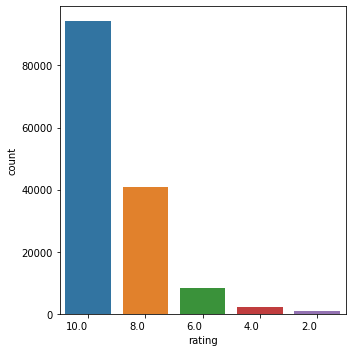

In [8]:
# Check distribution of data for each type
## ratings

print(df['rating'].value_counts())
print("")
print("")
plt.figure(figsize=(5,5))
ax = sns.countplot(x="rating", data=df, order = df['rating'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
plt.tight_layout()
plt.show()

In [9]:
# Before proceeding forward we will convert numeric strings to numeric

# Weight
df['weight'] = df['weight'].str.replace('lbs', '')
df['weight'] = df['weight'].astype('int')

# Rating
df['rating'] = df['rating'].astype('int')

# Age
df['age'] = df['age'].astype('int')

In [10]:
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,909926,34c,126335,135,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
3,fit,151944,34b,616682,145,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"
4,fit,734848,32b,364092,138,8,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,"5' 8""",8,45,"April 30, 2016"


In [11]:
# Unigram

wordCount = defaultdict(int)
punctuation = set(string.punctuation)
stemmer = PorterStemmer()
for i,d in df.iterrows():
    r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
    for w in r.split():
        w = stemmer.stem(w)
        wordCount[w] += 1

len(wordCount)

34676

In [12]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()
words = [x[1] for x in counts[:10000]]
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [13]:
df['rented for'].nunique()

9

In [14]:
df['fit'] = df['fit'].astype('category')
df['category'] = df['category'].astype('category')
df['body type'] = df['body type'].astype('category')
df['rented for'] = df['rented for'].astype('category')

In [15]:
df['bust_inch'] = 1
for i in range(df.shape[0]):
    df['bust_inch'][i] = df['bust size'][i][:2]
df['bust_inch'] = df['bust_inch'].astype('int')

<ipython-input-15-3ef4b8c011a7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bust_inch'][i] = df['bust size'][i][:2]


In [16]:
df['hgt'] = 1
for i in range(df.shape[0]):
    df['hgt'][i] = int(df['height'][i].split('\' ')[0])*12 + int(df['height'][i].split('\' ')[1].split("\"")[0])
df['hgt'] = df['hgt'].astype('int')

<ipython-input-16-0d9949799d42>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hgt'][i] = int(df['height'][i].split('\' ')[0])*12 + int(df['height'][i].split('\' ')[1].split("\"")[0])


In [17]:
df['ut'] = 1
for i in range(df.shape[0]):
    df['ut'][i] = time.mktime(time.strptime(df['review_date'][i], '%B %d, %Y'))
df['ut'] = df['ut'].astype('int')

<ipython-input-17-22bb4ca4aeca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ut'][i] = time.mktime(time.strptime(df['review_date'][i], '%B %d, %Y'))


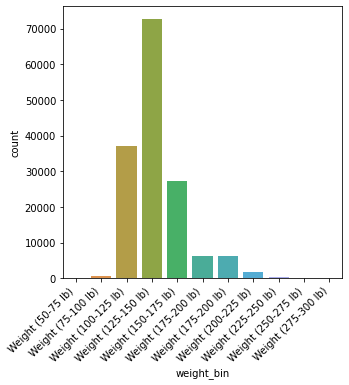

Weight (50-75 lb)          7
Weight (275-300 lb)       29
Weight (250-275 lb)      205
Weight (225-250 lb)      476
Weight (75-100 lb)       647
Weight (200-225 lb)     1892
Weight (175-200 lb)     6373
Weight (150-175 lb)    27172
Weight (100-125 lb)    37021
Weight (125-150 lb)    72559
Name: weight_bin, dtype: int64

In [18]:
def binning_operation(value):
    if value >= 50 and value < 75:
        column_value = 'Weight (50-75 lb)'
    elif value >= 75 and value < 100:
        column_value = 'Weight (75-100 lb)'
    elif value >= 100 and value < 125:
        column_value = 'Weight (100-125 lb)'
    elif value >= 125 and value < 150:
        column_value = 'Weight (125-150 lb)'
    elif value >= 150 and value < 175:
        column_value = 'Weight (150-175 lb)'
    elif value >= 175 and value < 200:
        column_value = 'Weight (175-200 lb)'
    elif value >= 200 and value < 225:
        column_value = 'Weight (200-225 lb)'
    elif value >= 225 and value < 250:
        column_value = 'Weight (225-250 lb)'
    elif value >= 250 and value < 275:
        column_value = 'Weight (250-275 lb)'
    elif value >= 275 and value <= 300:
        column_value = 'Weight (275-300 lb)'
    
    return column_value


df['weight_bin'] = df['weight'].apply(binning_operation)
order_list = ['Weight (50-75 lb)', 'Weight (75-100 lb)', 'Weight (100-125 lb)', 'Weight (125-150 lb)',
              'Weight (150-175 lb)', 'Weight (175-200 lb)', 'Weight (175-200 lb)', 'Weight (200-225 lb)',
              'Weight (225-250 lb)', 'Weight (250-275 lb)', 'Weight (275-300 lb)']

# Plot the distribution
plt.figure(figsize=(5,5))
ax = sns.countplot(x="weight_bin", data=df, order = order_list)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

# Print the count
df['weight_bin'].value_counts(ascending = True)

# Filtering data on weights

df = df[np.logical_and(df.weight >= 100, df.weight <= 200)]

<Figure size 360x360 with 0 Axes>

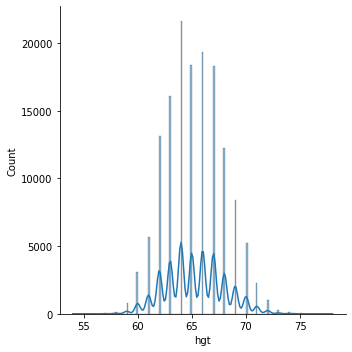

In [19]:
# Plot distribution for height

plt.figure(figsize=(5,5))
sns.displot(df['hgt'], kde=True)

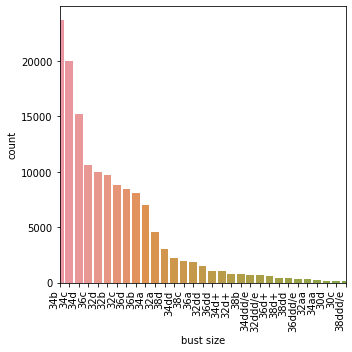

Number of Unique Categories for Bust Size: 101


In [20]:
# Distribution plot for Bust size

plt.figure(figsize=(5,5))
ax = sns.countplot(x="bust size", data=df, order = df['bust size'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_xlim(left = 0, right = 30)
plt.tight_layout()
plt.show()

# Total categories
print('Number of Unique Categories for Bust Size:', len(set(df['bust size'])))

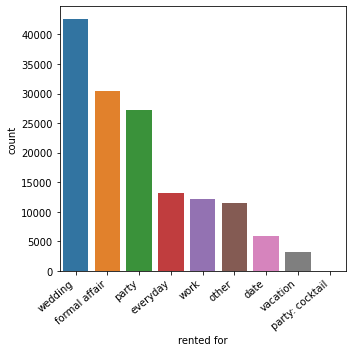

wedding            42622
formal affair      30496
party              27198
everyday           13263
work               12124
other              11510
date                5929
vacation            3238
party: cocktail        1
Name: rented for, dtype: int64

In [21]:
# Plot Distribution for 'rented for'

plt.figure(figsize=(5,5))
ax = sns.countplot(x="rented for", data=df, order = df['rented for'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

# Count Table
df['rented for'].value_counts()

In [22]:
# Filtering out 'party: cocktail'

df = df[df['rented for'] != 'party: cocktail']

   rating  len_review_text
0       2        54.349936
1       4        59.809070
2       6        66.416856
3       8        70.458047
4      10        64.996277


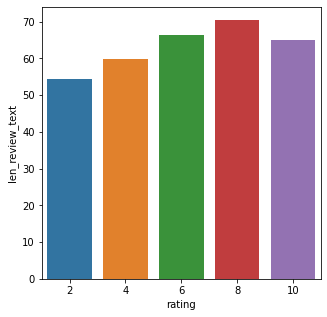

In [24]:
# Review Text Length Analysis

# Create column for length of review text
def len_review(review_text):
    length = len(review_text.split())
    return length

df['len_review_text'] = (df['review_text'] + ' ' + df['review_summary']).apply(len_review)

# Create Bar Plot
plt.figure(figsize=(5,5))
rating_len_review = df.groupby(by = 'rating')['len_review_text'].mean().reset_index()
rating_len_review
sns.barplot(data = rating_len_review, x = 'rating', y = 'len_review_text')
print(rating_len_review)

hourglass            43982
athletic             37518
petite               19357
pear                 18051
straight & narrow    12866
full bust            10797
apple                 3809
Name: body type, dtype: int64


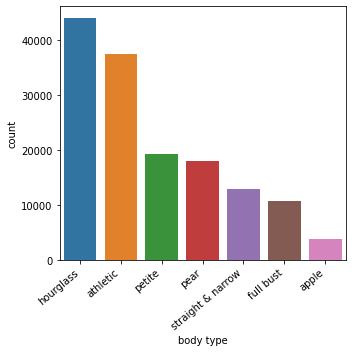

In [25]:
# Distribution plot for Body Type

print(df['body type'].value_counts(dropna=False))
plt.figure(figsize=(5,5))
ax = sns.countplot(x="body type", data=df, order = df['body type'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
#ax.set_xlim(left = 0, right = 50)
plt.tight_layout()
plt.show()

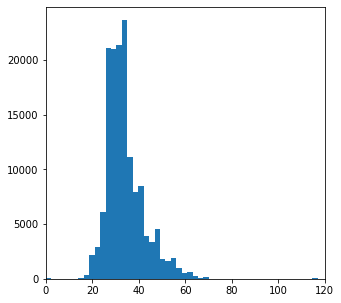

In [26]:
# Plot Distribution for Age

plt.figure(figsize = (5,5))
plt.hist(df['age'], bins = 50)
plt.xlim(0, 120)
plt.show()

In [28]:
# Filter out ages 0-15 and > 80 from df

df = df[np.logical_and(df.age > 15, df.age <= 80)]
df.shape

(146253, 20)

In [29]:
df.to_csv('data.csv', index = False, header = True)

In [30]:
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,bust_inch,hgt,ut,weight_bin,len_review_text
0,fit,420272,34d,2260466,137,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016",34,68,1461135600,Weight (125-150 lb),42
1,fit,273551,34b,153475,132,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013",34,66,1371538800,Weight (125-150 lb),45
2,fit,909926,34c,126335,135,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014",34,65,1392192000,Weight (125-150 lb),91
3,fit,151944,34b,616682,145,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016",34,69,1474873200,Weight (125-150 lb),118
4,fit,734848,32b,364092,138,8,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,"5' 8""",8,45,"April 30, 2016",32,68,1461999600,Weight (125-150 lb),43


In [34]:
data = df.drop(columns = ['user_id','bust size','item_id','height','weight_bin','review_date','category'])

In [35]:
data.head()

,fit,weight,rating,rented for,review_text,body type,review_summary,size,age,bust_inch,hgt,ut,len_review_text
0,fit,137,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,14,28,34,68,1461135600,42
1,fit,132,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,12,36,34,66,1371538800,45
2,fit,135,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,8,34,34,65,1392192000,91
3,fit,145,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,12,27,34,69,1474873200,118
4,fit,138,8,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,8,45,32,68,1461999600,43


In [33]:
data.nunique(axis = 0)

fit                     3
weight                186
rating                  5
rented for              8
review_text        145297
body type               7
review_summary     119586
size                   56
age                    62
bust_inch              11
hgt                    24
ut                   2239
len_review_text       395
dtype: int64

In [36]:
y = [d['rating'] for i,d in data.iterrows()]
data = data.drop(columns = ['rating'])

In [37]:
data = pd.get_dummies(data, columns = ['fit','rented for','body type'], drop_first=True)

In [38]:
data.head()

,weight,review_text,review_summary,size,age,bust_inch,hgt,ut,len_review_text,fit_large,...,rented for_party: cocktail,rented for_vacation,rented for_wedding,rented for_work,body type_athletic,body type_full bust,body type_hourglass,body type_pear,body type_petite,body type_straight & narrow
0,137,An adorable romper! Belt and zipper were a lit...,So many compliments!,14,28,34,68,1461135600,42,0,...,0,1,0,0,0,0,1,0,0,0
1,132,I rented this dress for a photo shoot. The the...,I felt so glamourous!!!,12,36,34,66,1371538800,45,0,...,0,0,0,0,0,0,0,0,0,1
2,135,I rented this for my company's black tie award...,Dress arrived on time and in perfect condition.,8,34,34,65,1392192000,91,0,...,0,0,0,0,0,0,0,1,0,0
3,145,I have always been petite in my upper body and...,Was in love with this dress !!!,12,27,34,69,1474873200,118,0,...,0,0,1,0,1,0,0,0,0,0
4,138,Didn't actually wear it. It fit perfectly. The...,Traditional with a touch a sass,8,45,32,68,1461999600,43,0,...,0,0,0,0,1,0,0,0,0,0


In [39]:
data = data.reset_index(drop = True)

In [40]:
# features for unigrams

data["text"] = data["review_summary"] + ' ' + data['review_text']

def preprocess_df(df):
    # get English stopwords
    en = spacy.load('en_core_web_sm')
    sw_spacy = en.Defaults.stop_words
    stop_words = set(sw_spacy)
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    preprocessed_sentences = []
    for i, row in df.iterrows():
        sent = row["text"].lower()
        sent_nopuncts = sent.translate(translator)
        words_list = sent_nopuncts.strip().split()
        filtered_words = [word for word in words_list if word not in stop_words and len(word) != 1] # also skip space from above translation
        preprocessed_sentences.append(" ".join(filtered_words))
    df["text"] = preprocessed_sentences
    return df

def build_vocab(sentences):
    word_counts = Counter(itertools.chain(*sentences))
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return word_counts, vocabulary, vocabulary_inv

def feature(d):
    feat = [0]*len(words)
    r = ''.join([c for c in d['text'].lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    #feat.append(1)
    return feat

In [42]:
df_pre = preprocess_df(data)

In [45]:
tagged_data = [word_tokenize(_d) for i, _d in enumerate(df_pre["text"])]
word_counts, vocabulary, vocabulary_inv = build_vocab(tagged_data)
inp_data = [[vocabulary[word] for word in text] for text in tagged_data]

In [56]:
tagged_data[:5] + [feature_1(d) for i,d in df_pre.iterrows()][:5]

[['adorable',
  'romper',
  'belt',
  'zipper',
  'little',
  'hard',
  'navigate',
  'day',
  'wear',
  'bathroom',
  'use',
  'expected',
  'wish',
  'pockets',
  'absolutely',
  'perfect',
  'got',
  'million',
  'compliments',
  'compliments'],
 ['rented',
  'dress',
  'photo',
  'shoot',
  'theme',
  'hollywood',
  'glam',
  'big',
  'beautiful',
  'hats',
  'dress',
  'comfortable',
  'easy',
  'definitely',
  'list',
  'rent',
  'formal',
  'event',
  'felt',
  'glamourous'],
 ['rented',
  'company',
  'black',
  'tie',
  'awards',
  'banquet',
  'liked',
  'dress',
  'short',
  'little',
  'fancier',
  'sequins',
  'generally',
  'don',
  'care',
  'long',
  'dresses',
  'describe',
  'color',
  'rose',
  'gold',
  'yellow',
  'gold',
  'blonde',
  'hair',
  'fair',
  'skin',
  'color',
  'flattering',
  'forgiving',
  'dress',
  'form',
  'fitting',
  'making',
  'feel',
  'like',
  'squeezed',
  'rent',
  'highly',
  'recommend',
  'dress',
  'arrived',
  'time',
  'perfect',

In [54]:
df_pre.shape

(146253, 26)

In [49]:
col_list = df_pre.columns.tolist()
col_list.pop(1)
col_list.pop(1)
col_list

'review_summary'

In [57]:
col_list

['weight',
 'size',
 'age',
 'bust_inch',
 'hgt',
 'ut',
 'len_review_text',
 'fit_large',
 'fit_small',
 'rented for_everyday',
 'rented for_formal affair',
 'rented for_other',
 'rented for_party',
 'rented for_party: cocktail',
 'rented for_vacation',
 'rented for_wedding',
 'rented for_work',
 'body type_athletic',
 'body type_full bust',
 'body type_hourglass',
 'body type_pear',
 'body type_petite',
 'body type_straight & narrow',
 'text']

In [50]:
# other features

def feature_1(d):
    feat = [1]
    for col in col_list:
        feat.append(d[col])
    return feat

In [35]:
X = [feature(d) + feature_1(d) for i,d in df_pre.iterrows()]
X = data.drop(columns = ['rating'])
y = data['rating']

In [36]:
data.shape

(143759, 24)

In [37]:
X_train = X[:120000]
X_test = X[120000:]
y_train = y[:120000]
y_test = y[120000:]

In [38]:
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

RandomForestRegressor()

In [39]:
y_pred = clf.predict(X_test)

In [40]:
mean_squared_error(y_pred,y_test)

1.9827776848101217

In [43]:
list(zip(X.columns, clf.feature_importances_))

[('weight', 0.11118574756442247),
 ('size', 0.06599127651746317),
 ('age', 0.11848201327768701),
 ('bust_inch', 0.03629591598578696),
 ('hgt', 0.08826761746797686),
 ('ut', 0.2156451801785871),
 ('len_review_text', 0.16812288150626506),
 ('fit_large', 0.032471949055459096),
 ('fit_small', 0.03273718361982273),
 ('rented for_everyday', 0.007948023185531465),
 ('rented for_formal affair', 0.008222085844031174),
 ('rented for_other', 0.008354909172233953),
 ('rented for_party', 0.011229455454163532),
 ('rented for_party: cocktail', 0.0),
 ('rented for_vacation', 0.0051118825408305755),
 ('rented for_wedding', 0.009371712485786556),
 ('rented for_work', 0.006514458965402614),
 ('body type_athletic', 0.015942910455135774),
 ('body type_full bust', 0.010122267511056186),
 ('body type_hourglass', 0.01695747397393104),
 ('body type_pear', 0.013062901243081904),
 ('body type_petite', 0.008684546204970951),
 ('body type_straight & narrow', 0.009277607790374029)]

In [41]:
cl = RandomForestClassifier(class_weight = 'balanced')
cl.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [42]:
print(classification_report(cl.predict(X_test),y_test))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         3
           4       0.02      0.27      0.03        22
           6       0.02      0.26      0.04       117
           8       0.14      0.39      0.20      2310
          10       0.93      0.67      0.78     21307

    accuracy                           0.64     23759
   macro avg       0.22      0.32      0.21     23759
weighted avg       0.85      0.64      0.72     23759



In [44]:
list(zip(X.columns, cl.feature_importances_))

[('weight', 0.11984827038235343),
 ('size', 0.08277474588044925),
 ('age', 0.12667052475928545),
 ('bust_inch', 0.04566539958841053),
 ('hgt', 0.09866054062704861),
 ('ut', 0.1808141772818105),
 ('len_review_text', 0.1648373592539944),
 ('fit_large', 0.019038995545664503),
 ('fit_small', 0.024687172381355083),
 ('rented for_everyday', 0.008307380345308906),
 ('rented for_formal affair', 0.010740719968236067),
 ('rented for_other', 0.00902490927031238),
 ('rented for_party', 0.012764321968634751),
 ('rented for_party: cocktail', 0.0),
 ('rented for_vacation', 0.004769145787839589),
 ('rented for_wedding', 0.011024439650428881),
 ('rented for_work', 0.007710519718977971),
 ('body type_athletic', 0.015574688929580669),
 ('body type_full bust', 0.009324178004238829),
 ('body type_hourglass', 0.017346181928069793),
 ('body type_pear', 0.011927171085876036),
 ('body type_petite', 0.009344807167176965),
 ('body type_straight & narrow', 0.009144350474947277)]

In [46]:
xg = XGBRegressor()
xg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [47]:
pred = xg.predict(X_test)

/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [48]:
mean_squared_error(pred,y_test)

1.8975495267350957

In [50]:
list(zip(X.columns, xg.feature_importances_))

[('weight', 0.02549891),
 ('size', 0.024641842),
 ('age', 0.022188278),
 ('bust_inch', 0.017365094),
 ('hgt', 0.019741058),
 ('ut', 0.027036443),
 ('len_review_text', 0.023490326),
 ('fit_large', 0.20723152),
 ('fit_small', 0.20755033),
 ('rented for_everyday', 0.07864257),
 ('rented for_formal affair', 0.033898357),
 ('rented for_other', 0.017306136),
 ('rented for_party', 0.021154065),
 ('rented for_party: cocktail', 0.0),
 ('rented for_vacation', 0.022167934),
 ('rented for_wedding', 0.052300196),
 ('rented for_work', 0.076209955),
 ('body type_athletic', 0.016624661),
 ('body type_full bust', 0.024591554),
 ('body type_hourglass', 0.017142428),
 ('body type_pear', 0.02021146),
 ('body type_petite', 0.025224159),
 ('body type_straight & narrow', 0.019782672)]

In [51]:
xgc = XGBClassifier(class_weight = 'balanced')
xgc.fit(X_train,y_train)

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:07:48] WARNING: ../src/learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:07:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [52]:
print(classification_report(xgc.predict(X_test),y_test))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         5
           4       0.01      0.20      0.02        15
           6       0.02      0.37      0.04        87
           8       0.12      0.41      0.18      1880
          10       0.95      0.67      0.78     21772

    accuracy                           0.65     23759
   macro avg       0.22      0.33      0.20     23759
weighted avg       0.88      0.65      0.73     23759



/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
